### Step 4: Data Wrangling

The raw output data from coregistration step cannot be passed into machine learning model directly. They don't have labels and have too many features. 

The label is the thing we will try to predict with the machine learning models. In our case, the label is a True or False assertion. Each input data row is either a mineral deposit or not a mineral deposit. Given a data row, the machine learning model will tell us if the location is a mineral deposit or not. This is the ultimate goal we are trying to achieve in this machine learning workflow.

The feature is a column of the input data. There are too many columns in the coregistration output data. It is not wise to use so many features in the machine learning analysis because of the [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). More features mean more dimensions. If you have 20 features/columns, the machine learning model has to do the analysis in a 20-dimensional space. Just imagine it, if you were thrown into a 20-dimensional space, I guess it would not be a happy experience to find a way out. Yes, some machine learning models are smart enough and can reduce the number of dimensions. But at the current point of human history, humans are still a little bit smarter than computers. So, let's help computers by reducing the number of features.

We will create a csv file, in which the last colomn is the label(0 or 1) and the other columns are features. 

The feature selection is highly related to the specific research. We need to identify the features which are most important to the formation of mineral deposit. For example, some researchers might think the distance along the trench is important. Others might think the sea floor age is of great significance. Come out with your own hypothesis, wrangle the data accordingly and then send the data into machine learning model to be evaluated. Repeat this process until we find the most important featueres and then we can train the machine learning model to predict mineral deposits on new dataset. This process is similar to a psychic finds a perfect crystal ball and starts a fortune telling business. The only difference is that the psychic is doing magic, but we are doing science.

The following code cell will select features from coregistration output and create a csv file for the machine learning analysis in Step 5.

In [1]:
import numpy as np
import pandas as pd
from parameters import parameters as p
import Utils

#load data 
coreg_input_data = pd.read_csv(p['input_file'])
coreg_output_data = pd.read_csv('coreg_output/0_vector_subStats.out', header=None)
print('The shape of coregistration input data is: ', coreg_input_data.shape)
print('The shape of coregistration output data is: ', coreg_output_data.shape)

if coreg_input_data.shape[0] == coreg_output_data.shape[0]:
    print('Good! The input and output data has the same length ', coreg_output_data.shape[0])

print()
print('the coregistration input data')
display(coreg_input_data)
print('the coregistration output data')
display(coreg_output_data)
print('the columns in coregistration output data are: ')
Utils.print_columns()



The shape of coregistration input data is:  (92540, 5)
The shape of coregistration output data is:  (92540, 29)
Good! The input and output data has the same length  92540

the coregistration input data


,index,lon,lat,age,plate_id
0,0,-66.28,-27.37,6,201
1,1,-69.37,-31.30,230,201
2,2,-69.75,-30.50,12,201
3,3,-66.65,-27.27,9,201
4,4,-66.61,-27.33,8,201
...,...,...,...,...,...
92535,92535,-71.12,-22.54,229,201
92536,92536,-71.10,-22.37,229,201
92537,92537,-71.09,-22.19,229,201
92538,92538,-71.08,-21.84,229,201


the coregistration output data


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,-65.22,-27.06,0.08,899.0,-70.50,-26.45,10.88,-14.88,1.86,156.60,...,0.74,-9.04,-13.09,8.81,-2.05,57.29,0.18,111.16,2209.35,2.15
1,-53.94,-50.18,0.05,1353.0,-57.88,-49.44,2.72,-20.72,2.31,-133.74,...,-1.67,-2.78,-70.37,0.93,-2.62,65.70,0.05,0.66,182.23,0.73
2,-67.52,-29.97,0.04,921.0,-70.12,-29.79,11.88,-12.51,2.56,177.24,...,0.12,-9.37,-15.11,9.05,-2.44,61.96,0.21,85.92,2362.22,2.24
3,-65.06,-26.82,0.08,937.0,-69.97,-26.30,10.87,-14.77,1.85,157.04,...,0.72,-9.04,-13.05,8.81,-2.04,73.53,0.20,83.81,2462.38,2.45
4,-65.20,-26.93,0.08,915.0,-70.15,-26.35,10.87,-14.81,1.86,156.89,...,0.73,-9.04,-13.07,8.81,-2.04,74.62,0.20,117.03,2404.62,2.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92535,-53.84,-41.10,0.00,1566.0,-53.84,-41.10,6.55,7.03,2.26,-132.02,...,-1.68,-5.06,-9.94,4.98,-0.87,55.40,0.10,8.51,223.73,1.78
92536,-53.77,-40.93,0.00,1567.0,-53.78,-40.93,6.53,7.05,2.26,-131.98,...,-1.68,-5.04,-9.96,4.97,-0.87,55.40,0.10,8.51,223.73,1.78
92537,-53.72,-40.76,0.00,1569.0,-53.72,-40.76,6.52,7.07,2.26,-131.95,...,-1.68,-5.03,-9.99,4.95,-0.87,55.40,0.10,8.51,223.73,1.78
92538,-53.62,-40.42,0.00,1577.0,-53.62,-40.42,6.49,23.46,2.25,-115.54,...,-2.03,-5.00,6.32,4.97,0.55,55.40,0.09,8.51,223.73,1.78


the columns in coregistration output data are: 
* 0 reconstructed mineral deposits longitude
* 1 reconstructed mineral deposits latitude
* 2 distance to the nearest trench point
* 3 the index of trench point
* 4 trench point longitude
* 5 trench point latitude
* 6 subducting convergence (relative to trench) velocity magnitude (in cm/yr)
* 7 subducting convergence velocity obliquity angle (angle between trench normal vector and convergence velocity vector)
* 8 trench absolute (relative to anchor plate) velocity magnitude (in cm/yr)
* 9 trench absolute velocity obliquity angle (angle between trench normal vector and trench absolute velocity vector)
* 10 length of arc segment (in degrees) that current point is on
* 11 trench normal azimuth angle (clockwise starting at North, ie, 0 to 360 degrees) at current point
* 12 subducting plate ID
* 13 trench plate ID
* 14 distance (in degrees) along the trench line to the nearest trench edge
* 15 the distance (in degrees) along the trench line fro

##### After having a look at the data, let's start selecting features and add labels.

In [2]:
def select_features(coreg_output_data, coreg_input_data, deposit_len, column_indices, 
                    column_names, file_name_prefix):
    feature_data = coreg_output_data[column_indices]
    feature_data.columns = column_names
    print(f'the data after selecting {len(column_indices)} features ')
    display(feature_data)

    #Now we append lables to the last column. 1 means deposit. 0 means non-deposit
    feature_data_with_label = pd.concat([feature_data, pd.DataFrame([1]*deposit_len+[0]*(len(coreg_input_data)-deposit_len), 
                                                 columns=['Label'])], axis=1)
    print('the data after adding the labels ')
    print(f'only the first {deposit_len} rows are deposits ')
    display(feature_data_with_label)

    all_data = pd.concat([coreg_input_data,coreg_output_data],axis=1)
    
    #divide the whole dataset into two parts and drop all the rows with nan values
    deposits_data = feature_data_with_label[:deposit_len*2].dropna()
    trench_data = feature_data_with_label[deposit_len*2-1:].dropna()

    print('the shape of deposits data is: ', deposits_data.shape)
    print('the shape of trench data is: ', trench_data.shape)
    
    #save the data
    deposits_data.to_csv(file_name_prefix+'_deposit_feature_and_label.csv',index=False)
    trench_data.to_csv(file_name_prefix+'_trench_feature_and_label.csv',index=False)

    all_data.iloc[deposits_data.index].to_csv(file_name_prefix+'_deposit_all_data.csv',index=False)
    all_data.iloc[trench_data.index].to_csv(file_name_prefix+'_trench_all_data.csv',index=False)
   

print('The number in the file name is the number of mineral deposits ', p['input_file'])
#get the number of mineral deposits from the file name
import re
deposit_len = int(re.split(r'_|\.', p['input_file'])[-2])
print(f'There are {deposit_len} mineral deposits.\n')

#
# LOOK HERE!!!!
# choose the features here
# see the list above for column indices
# the column name can be any string, but the length of column_names must equal length of column_indices
#
column_indices = [24, 15, 18, 16, 17, 26, 27, 28]
column_names = ['Seafloor Age', 'Distance Along Trench', 'Trench Absolute Orthogonal', 
        'Convergence Orthogonal', 'Convergence Parallel', 'decompacted sediment thickness',
                'sediment thickness', 'ocean crust carbon percent']

#let's select features 
select_features(coreg_output_data, coreg_input_data, deposit_len, column_indices, 
                    column_names, 'testcase_1')

import glob
files = glob.glob('./testcase_1*.csv')
print('\ngenerated files:')
for f in files:
    print(f)

The number in the file name is the number of mineral deposits  coregistration_input_data_example_155.csv
There are 155 mineral deposits.

the data after selecting 8 features 


,Seafloor Age,Distance Along Trench,Trench Absolute Orthogonal,Convergence Orthogonal,Convergence Parallel,decompacted sediment thickness,sediment thickness,ocean crust carbon percent
0,57.29,25.77,-1.71,10.51,-2.79,111.16,2209.35,2.15
1,65.70,4.78,-1.60,2.54,-0.96,0.66,182.23,0.73
2,61.96,22.38,-2.55,11.60,-2.57,85.92,2362.22,2.24
3,73.53,25.60,-1.71,10.51,-2.77,83.81,2462.38,2.45
4,74.62,25.65,-1.71,10.51,-2.78,117.03,2404.62,2.45
...,...,...,...,...,...,...,...,...
92535,55.40,13.46,-1.51,6.50,0.80,8.51,223.73,1.78
92536,55.40,13.64,-1.51,6.48,0.80,8.51,223.73,1.78
92537,55.40,13.81,-1.51,6.47,0.80,8.51,223.73,1.78
92538,55.40,14.17,-0.97,5.95,2.58,8.51,223.73,1.78


the data after adding the labels 
only the first 155 rows are deposits 


,Seafloor Age,Distance Along Trench,Trench Absolute Orthogonal,Convergence Orthogonal,Convergence Parallel,decompacted sediment thickness,sediment thickness,ocean crust carbon percent,Label
0,57.29,25.77,-1.71,10.51,-2.79,111.16,2209.35,2.15,1
1,65.70,4.78,-1.60,2.54,-0.96,0.66,182.23,0.73,1
2,61.96,22.38,-2.55,11.60,-2.57,85.92,2362.22,2.24,1
3,73.53,25.60,-1.71,10.51,-2.77,83.81,2462.38,2.45,1
4,74.62,25.65,-1.71,10.51,-2.78,117.03,2404.62,2.45,1
...,...,...,...,...,...,...,...,...,...
92535,55.40,13.46,-1.51,6.50,0.80,8.51,223.73,1.78,0
92536,55.40,13.64,-1.51,6.48,0.80,8.51,223.73,1.78,0
92537,55.40,13.81,-1.51,6.47,0.80,8.51,223.73,1.78,0
92538,55.40,14.17,-0.97,5.95,2.58,8.51,223.73,1.78,0


the shape of deposits data is:  (310, 9)
the shape of trench data is:  (91010, 9)

generated files:
./testcase_1_trench_feature_and_label.csv
./testcase_1_trench_all_data.csv
./testcase_1_deposit_feature_and_label.csv
./testcase_1_deposit_all_data.csv


#### The dataset has 5 features(dimensions). It is difficult to visualize the data in high dimensional space. So, let's plot it in two dimensions. 

Sometimes we can see a little bit the pattern of mineral deposit distribution in the 2D plots. Sometimes we cannot. For example, it seems there are many mineral deposits when the seafloor age is between 20 and 110 in the below plot. 

The machine learning models can help us to find out the distribution pattern in a higher dimensional space, which might not emerge in a lower dimensional space. Machine learning analysis cannot tell us the exact distribution pattern, but it can give us an estimation with certain accuracy. 

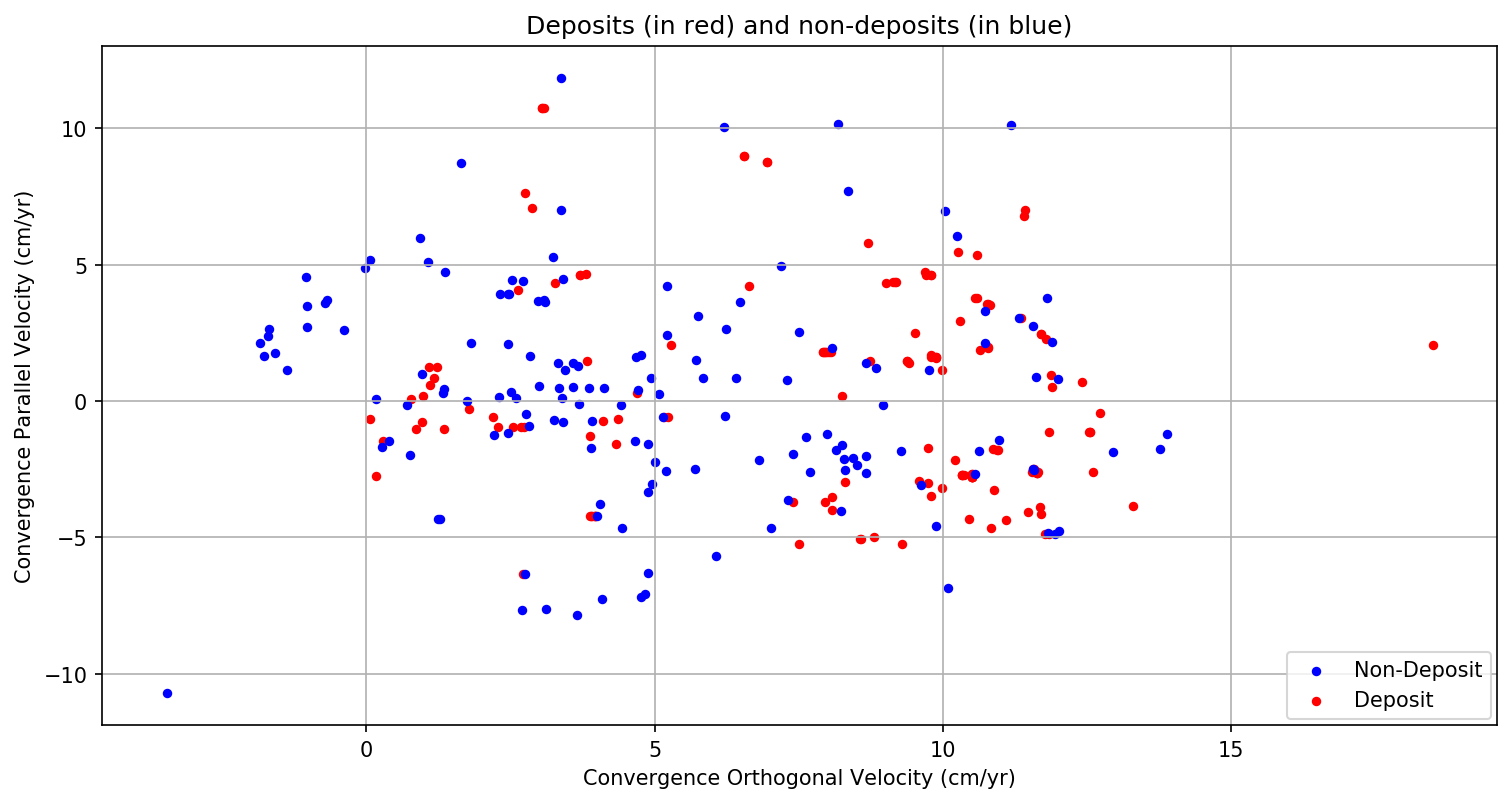

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12,6),dpi=150)
ax = plt.axes()

deposits_data = pd.read_csv('testcase_1_deposit_feature_and_label.csv')

positive = deposits_data[deposits_data['Label']==1]
negative = deposits_data[deposits_data['Label']==0]

p1=ax.scatter(positive['Convergence Orthogonal'], 
           positive['Convergence Parallel'],
           50, marker='.',c='red')
p2=ax.scatter(negative['Convergence Orthogonal'], 
           negative['Convergence Parallel'], 
           50, marker='.',c='blue')
#ax.set_xticks(np.arange(0,231,10))
#ax.set_yticks(np.arange(0,8000,500))
plt.xlabel('Convergence Orthogonal Velocity (cm/yr)')
plt.ylabel('Convergence Parallel Velocity (cm/yr)')
plt.title('Deposits (in red) and non-deposits (in blue)')
ax.legend([p2,p1],["Non-Deposit","Deposit"],
            loc=4, borderaxespad=0.3,numpoints=1)
plt.grid()
plt.show()


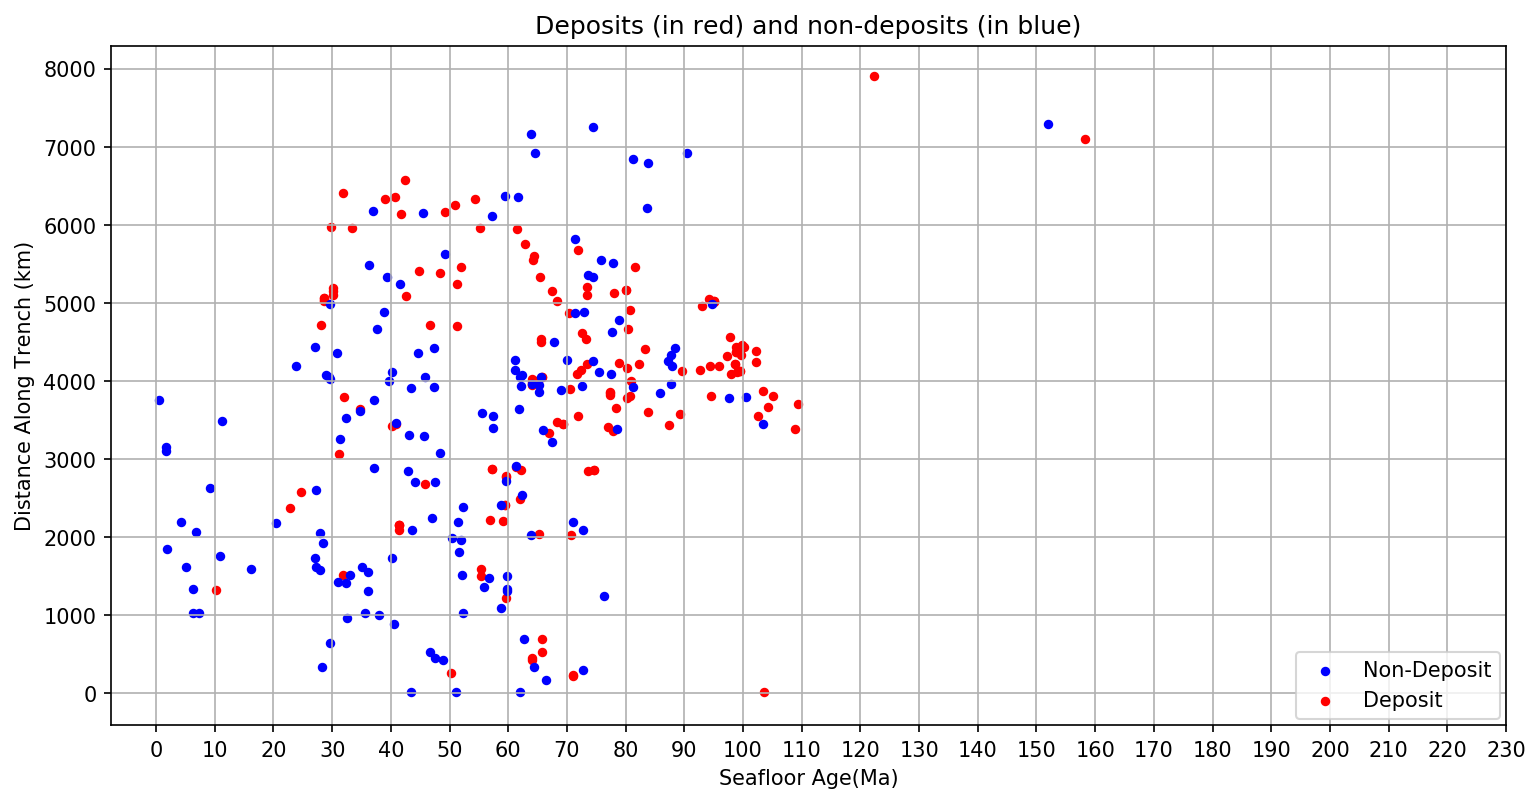

In [4]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(12,6),dpi=150)
ax = plt.axes()

positive = deposits_data[deposits_data['Label']==1]
negative = deposits_data[deposits_data['Label']==0]

p1=ax.scatter(positive['Seafloor Age'], 
           positive['Distance Along Trench']* 6371. * np.pi / 180,
           50, marker='.',c='red')
p2=ax.scatter(negative['Seafloor Age'], 
           negative['Distance Along Trench']* 6371. * np.pi / 180, 
           50, marker='.',c='blue')
ax.set_xticks(np.arange(0,231,10))
#ax.set_yticks(np.arange(0,8000,500))
plt.xlabel('Seafloor Age(Ma)')
plt.ylabel('Distance Along Trench (km)')
plt.title('Deposits (in red) and non-deposits (in blue)')
ax.legend([p2,p1],["Non-Deposit","Deposit"],
            loc=4, borderaxespad=0.3,numpoints=1)
plt.grid()
plt.show()


##### Let's try to plot it in a 3-dimensional space

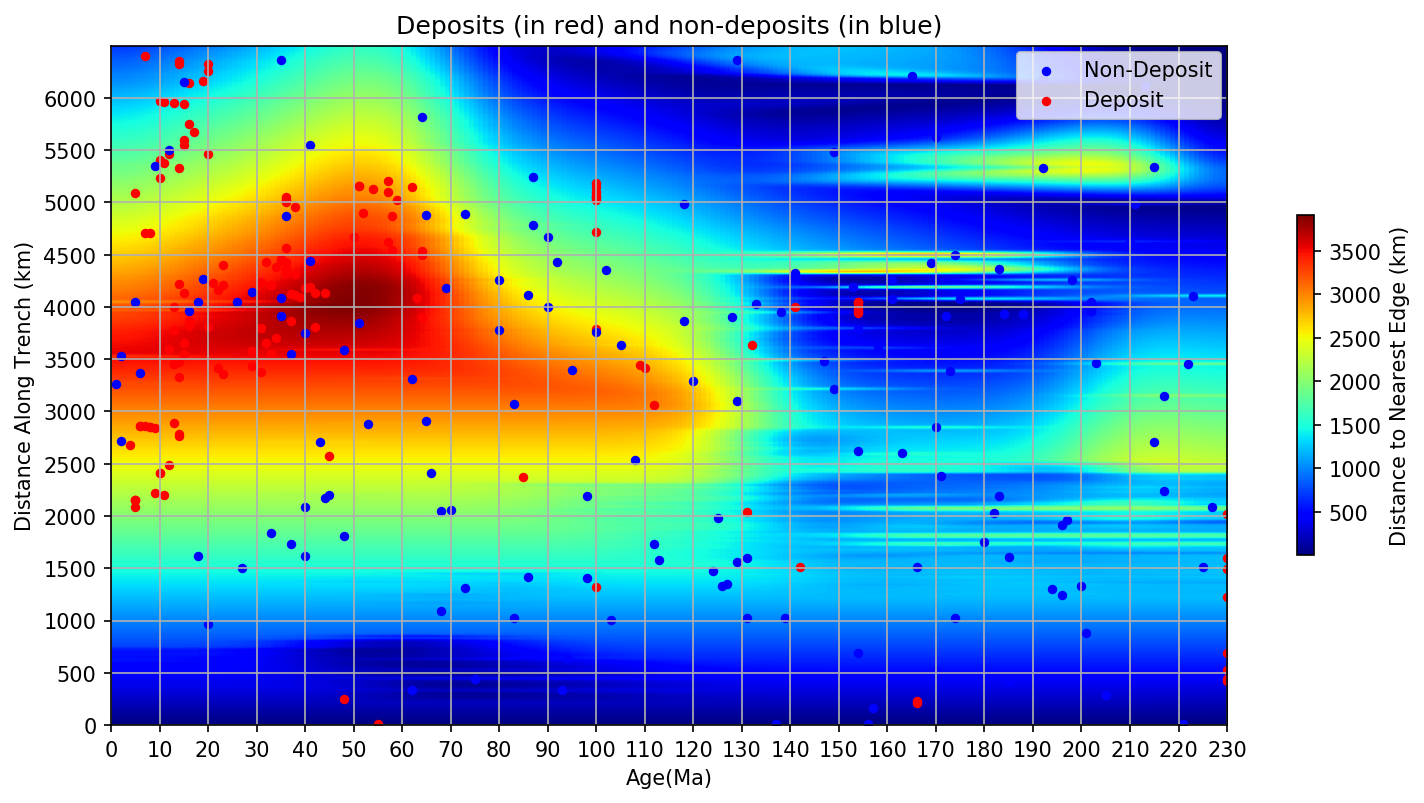

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy as np
from scipy import misc, ndimage

data = pd.concat([coreg_output_data, 
                  coreg_input_data, 
                  pd.DataFrame([1]*deposit_len+[0]*(len(coreg_input_data)-deposit_len), columns=['Label'])], 
                 axis=1)
#display(data)

deposit_data = data[:deposit_len*2].dropna()
positive = deposit_data[deposit_data['Label']==1]
negative = deposit_data[deposit_data['Label']==0]
trench_data = data[deposit_len*2-1:].dropna()

data=data.dropna()
ages = data['age'].values.tolist()
dist_along_trench=(data[15]* 6371. * np.pi / 180).values.tolist()
dist_nearest_edge=(data[14]* 6371. * np.pi / 180).values.tolist()


fig = plt.figure(figsize=(12,6),dpi=150)
ax = plt.axes()
plt.xlim([0,230])
plt.ylim([0,6500])

grid_x, grid_y = np.mgrid[0:231, 0:6501]
grid_data = griddata(list(zip(ages, dist_along_trench)), dist_nearest_edge, 
                     (grid_x, grid_y), method='linear', fill_value=0)
grid_data = ndimage.gaussian_filter(grid_data, sigma=10)
cb=plt.imshow(grid_data.T, extent=(0,230,0, 6500), origin='lower', aspect='auto',cmap=plt.cm.jet)
#cb=ax.scatter(ages, dist_along_trench, c=dist_nearest_edge,cmap=plt.cm.jet)
p1=ax.scatter(positive['age'], positive[15]* 6371. * np.pi / 180, 50, marker='.',c='red')
p2=ax.scatter(negative['age'], negative[15]* 6371. * np.pi / 180, 50, marker='.',c='blue')
ax.set_xticks(np.arange(0,240,10))
ax.set_yticks(np.arange(0,6500,500))
plt.xlabel('Age(Ma)')
plt.ylabel('Distance Along Trench (km)')
plt.title('Deposits (in red) and non-deposits (in blue)')
plt.grid()
ax.legend([p2,p1],["Non-Deposit","Deposit"],
            loc=1, borderaxespad=0.3,numpoints=1)
fig.colorbar(cb, shrink=0.5, label='Distance to Nearest Edge (km)')

plt.show()

#### Note:
The construction of multiple dimensional space(what we have done in this notebook) is important because the deposit distribution might be clearer to see in one space than the other. Choose your features carefully and wisely. And be aware of the [Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality).

#### This is the end of step 4 and now open the step 5 notebook
[5_Machine_Learning.ipynb](5_Machine_Learning.ipynb)